In [34]:
import carla, time, pygame, math, random, cv2
import numpy as np

client = carla.Client('localhost', 2000)
client.set_timeout(20.0)
client.load_world('Town05')
world = client.get_world()
spectator = world.get_spectator()

In [36]:
def move_spectator_to(transform, distance=5.0, x=0, y=0, z=4, yaw=0, pitch=-30, roll=0):
    back_location = transform.location - transform.get_forward_vector() * distance
    
    back_location.x += x
    back_location.y += y
    back_location.z += z
    transform.rotation.yaw += yaw
    transform.rotation.pitch = pitch
    transform.rotation.roll = roll
    
    spectator_transform = carla.Transform(back_location, transform.rotation)
    
    spectator.set_transform(spectator_transform)

def spawn_vehicle(vehicle_index=0, spawn_index=0, pattern='vehicle.*'):
    blueprint_library = world.get_blueprint_library()
    vehicle_bp = blueprint_library.filter(pattern)[vehicle_index]
    spawn_point = world.get_map().get_spawn_points()[spawn_index]
    vehicle = world.spawn_actor(vehicle_bp, spawn_point)
    return vehicle

def draw_on_screen(world, transform, content='O', color=carla.Color(0, 255, 0), life_time=20):
    world.debug.draw_string(transform.location, content, color=color, life_time=life_time)

def spawn_camera(attach_to=None, transform=carla.Transform(carla.Location(x=1.2, z=1.2), carla.Rotation(pitch=-30)), width=800, height=600):
    camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
    camera_bp.set_attribute('image_size_x', str(width))
    camera_bp.set_attribute('image_size_y', str(height))
    camera = world.spawn_actor(camera_bp, transform, attach_to=attach_to)
    return camera

In [38]:
camera_position = carla.Transform(carla.Location(x=-34, y=31, z=11), carla.Rotation(pitch=-38, yaw=-170, roll=0))

camera = spawn_camera(transform=camera_position)
vehicle = spawn_vehicle()

camera.listen(lambda image: image.save_to_disk('output/camera.png'))

time.sleep(2)

camera.destroy()
vehicle.destroy()

True

In [10]:
sensors = world.get_blueprint_library().filter('sensor.*')

for sensor in sensors:
    print(sensor.id)

sensor.other.collision
sensor.camera.depth
sensor.camera.optical_flow
sensor.camera.normals
sensor.other.lane_invasion
sensor.camera.dvs
sensor.other.imu
sensor.other.gnss
sensor.other.obstacle
sensor.other.radar
sensor.lidar.ray_cast_semantic
sensor.lidar.ray_cast
sensor.camera.rgb
sensor.camera.semantic_segmentation
sensor.other.rss
sensor.camera.instance_segmentation


In [39]:
def spawn_camera_depth(attach_to=None, transform=carla.Transform(carla.Location(x=1.2, z=1.2), carla.Rotation(pitch=-30)), width=800, height=600):
    camera_bp = world.get_blueprint_library().find('sensor.camera.depth')
    camera_bp.set_attribute('image_size_x', str(width))
    camera_bp.set_attribute('image_size_y', str(height))
    camera = world.spawn_actor(camera_bp, transform, attach_to=attach_to)
    return camera

camera_position = carla.Transform(carla.Location(x=-34, y=31, z=11), carla.Rotation(pitch=-38, yaw=-170, roll=0))

camera = spawn_camera_depth(transform=camera_position)
vehicle = spawn_vehicle()

def proces(image):
    image = carla.ColorConverter.LogarithmicDepth(image)
    image.save_to_disk('output/camera_depth.png')

camera.listen(lambda image: image.save_to_disk("output/camera1.png"))

time.sleep(2)

camera.destroy()
vehicle.destroy()

True

[[[27.91405   27.91405   27.91405  ]
  [28.003992  28.003992  28.003992 ]
  [28.094473  28.094473  28.094473 ]
  ...
  [37.648083  37.648083  37.648083 ]
  [37.570717  37.570717  37.570717 ]
  [37.49365   37.49365   37.49365  ]]

 [[27.904333  27.904333  27.904333 ]
  [27.994158  27.994158  27.994158 ]
  [28.084637  28.084637  28.084637 ]
  ...
  [37.656487  37.656487  37.656487 ]
  [37.57912   37.57912   37.57912  ]
  [37.50199   37.50199   37.50199  ]]

 [[27.894617  27.894617  27.894617 ]
  [27.984383  27.984383  27.984383 ]
  [28.074802  28.074802  28.074802 ]
  ...
  [37.664894  37.664894  37.664894 ]
  [37.587467  37.587467  37.587467 ]
  [37.510338  37.510338  37.510338 ]]

 ...

 [[ 8.982063   8.982063   8.982063 ]
  [ 8.982122   8.982122   8.982122 ]
  [ 8.9821825  8.9821825  8.9821825]
  ...
  [ 8.982838   8.982838   8.982838 ]
  [ 8.982838   8.982838   8.982838 ]
  [ 8.982838   8.982838   8.982838 ]]

 [[ 8.967758   8.967758   8.967758 ]
  [ 8.666456   8.666456   8.666456 ]


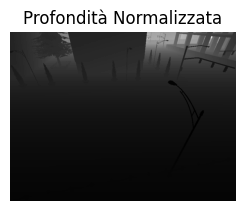

In [40]:
import matplotlib.pyplot as plt

def normalizza_pixel(R, G, B):
    normalized = (R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1)
    in_meters = 1000 * normalized
    return in_meters

# Funzione per applicare la normalizzazione a tutta l'immagine
def normalizza_immagine(image):
    # Crea un'immagine vuota per il risultato
    result_image = np.zeros(image.shape, dtype=np.float32)
    
    # Itera attraverso ogni pixel dell'immagine
    for i in range(image.shape[0]):  # Ciclo per le righe
        for j in range(image.shape[1]):  # Ciclo per le colonne
            R, G, B = image[i, j]  # Estrai i valori RGB
            result_image[i, j] = normalizza_pixel(R, G, B)  # Normalizza e converte in metri
    
    return result_image

# Carica un'immagine RGB (ad esempio 'image.jpg')
image = cv2.imread("output/camera1.png")  # Carica l'immagine

# Assicurati che l'immagine sia in formato RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Normalizza l'immagine
normalized_image = normalizza_immagine(image_rgb)
print(normalized_image)

def converti_grayscale(normalized_image):
    # Calcola la media dei tre canali per ogni pixel
    grayscale_image = np.mean(normalized_image, axis=-1)
    
    # Normalizza l'immagine in scala di grigi per il range [0, 255]
    grayscale_image = (grayscale_image - np.min(grayscale_image)) / (np.max(grayscale_image) - np.min(grayscale_image)) * 255
    grayscale_image = grayscale_image.astype(np.uint8)  # Converte i valori in uint8 per visualizzare correttamente
    
    return grayscale_image

# Converti l'immagine normalizzata in scala di grigi
grayscale_image = converti_grayscale(normalized_image)

# Ora normalized_image contiene l'immagine normalizzata in "metri"

# Mostra l'immagine di profondità normalizzata
plt.subplot(1, 2, 2)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Profondità Normalizzata')
plt.axis('off')

plt.show()

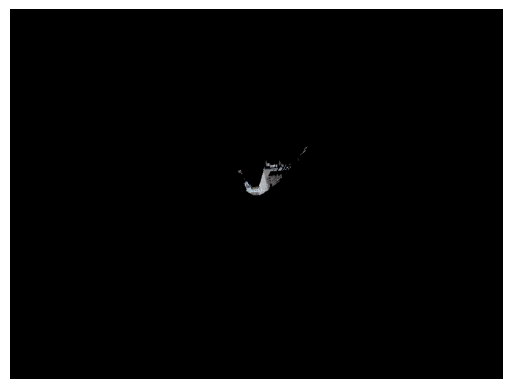

True

In [41]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_top_view(depth_img, rgb_img, fx, fy, cx, cy):
    """
    Crea una vista dall'alto combinando la mappa di profondità e l'immagine RGB.
    
    depth_img: Immagine di profondità in scala di grigi (valori di profondità)
    rgb_img: Immagine RGB
    fx, fy: Focali della fotocamera
    cx, cy: Coordinate del centro dell'immagine
    """
    
    # Assicurati che le immagini abbiano le stesse dimensioni
    assert depth_img.shape[:2] == rgb_img.shape[:2], "Le immagini devono avere le stesse dimensioni"

    # Crea un array vuoto per la vista dall'alto
    top_view = np.zeros_like(rgb_img)

    # Numero di righe e colonne nell'immagine
    rows, cols = depth_img.shape[:2]

    for i in range(rows):
        for j in range(cols):
            # Estrai la profondità in metri (assumendo che la profondità sia già in unità metriche)
            z = depth_img[i, j]
            
            if z == 0:  # Se la profondità è zero (non definita), ignora questo pixel
                continue
            
            # Calcola le coordinate 3D (x, y) usando la mappa di profondità
            x = (j - cx) * z / fx
            y = (i - cy) * z / fy
            
            # Proietta la posizione nel piano 2D della vista dall'alto (ignoriamo la profondità)
            # Puoi usare una semplice trasformazione per ottenere la vista dall'alto
            top_x = int(x + cols // 2)  # Centra la scena
            top_y = int(y + rows // 2)  # Centra la scena
            
            # Verifica se la proiezione rientra nei limiti dell'immagine
            if 0 <= top_x < cols and 0 <= top_y < rows:
                # Copia il colore dall'immagine RGB alla vista dall'alto
                top_view[top_y, top_x] = rgb_img[i, j]
    
    return top_view

# Carica l'immagine di profondità e RGB
depth_img = grayscale_image  # Immagine di profondità in scala di grigi
rgb_img = cv2.imread("output/camera.png")  # Immagine RGB

# Parametri della fotocamera (esempi, dovresti usare i tuoi valori)
fx = 1000  # Focale in pixel (x)
fy = 1000  # Focale in pixel (y)
cx = rgb_img.shape[1] // 2  # Centro dell'immagine (x)
cy = rgb_img.shape[0] // 2  # Centro dell'immagine (y)

# Crea la vista dall'alto
top_view = create_top_view(depth_img, rgb_img, fx, fy, cx, cy)

# Mostra l'immagine della vista dall'alto
plt.imshow(top_view)
plt.axis('off')
plt.show()

# Salva l'immagine risultante
cv2.imwrite('top_view.png', top_view)


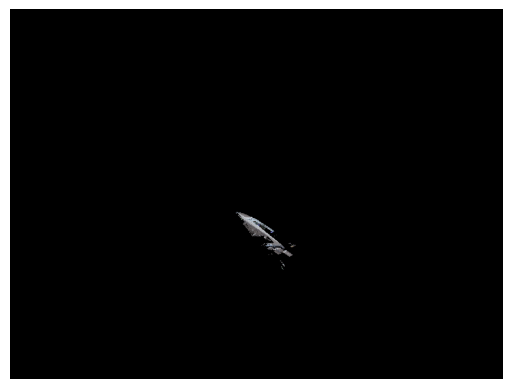

True

In [43]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

def create_top_view_with_camera(depth_img, rgb_img, fx, fy, cx, cy, cam_location, cam_rotation):
    """
    Crea una vista dall'alto combinando la mappa di profondità, l'immagine RGB e la posizione/rotazione della fotocamera.
    
    depth_img: Immagine di profondità in scala di grigi (valori di profondità)
    rgb_img: Immagine RGB
    fx, fy: Focali della fotocamera
    cx, cy: Coordinate del centro dell'immagine
    cam_location: Posizione della fotocamera (x, y, z)
    cam_rotation: Rotazione della fotocamera (pitch, yaw, roll)
    """
    
    # Assicurati che le immagini abbiano le stesse dimensioni
    assert depth_img.shape[:2] == rgb_img.shape[:2], "Le immagini devono avere le stesse dimensioni"
    
    # Crea un array vuoto per la vista dall'alto
    top_view = np.zeros_like(rgb_img)
    
    # Numero di righe e colonne nell'immagine
    rows, cols = depth_img.shape[:2]

    # Converte gli angoli di rotazione da gradi a radianti
    pitch_rad = math.radians(cam_rotation.pitch)
    yaw_rad = math.radians(cam_rotation.yaw)
    roll_rad = math.radians(cam_rotation.roll)

    # Matrice di rotazione della fotocamera (roll, pitch, yaw)
    R = np.array([
        [math.cos(yaw_rad)*math.cos(pitch_rad), math.cos(yaw_rad)*math.sin(pitch_rad)*math.sin(roll_rad) - math.sin(yaw_rad)*math.cos(roll_rad), math.cos(yaw_rad)*math.sin(pitch_rad)*math.cos(roll_rad) + math.sin(yaw_rad)*math.sin(roll_rad)],
        [math.sin(yaw_rad)*math.cos(pitch_rad), math.sin(yaw_rad)*math.sin(pitch_rad)*math.sin(roll_rad) + math.cos(yaw_rad)*math.cos(roll_rad), math.sin(yaw_rad)*math.sin(pitch_rad)*math.cos(roll_rad) - math.cos(yaw_rad)*math.sin(roll_rad)],
        [-math.sin(pitch_rad), math.cos(pitch_rad)*math.sin(roll_rad), math.cos(pitch_rad)*math.cos(roll_rad)]
    ])
    
    # Posizione della fotocamera
    cam_pos = np.array([cam_location.x, cam_location.y, cam_location.z])
    
    for i in range(rows):
        for j in range(cols):
            # Estrai la profondità in metri (assumendo che la profondità sia già in unità metriche)
            z = depth_img[i, j]
            
            if z == 0:  # Se la profondità è zero (non definita), ignora questo pixel
                continue
            
            # Calcola le coordinate 3D (x, y) usando la mappa di profondità
            x = (j - cx) * z / fx
            y = (i - cy) * z / fy
            point_3d = np.array([x, y, z])
            
            # Trasforma il punto 3D dalla fotocamera alla scena
            # Punto 3D nella scena globale
            point_3d_world = np.dot(R, point_3d) + cam_pos
            
            # Proietta la posizione nel piano 2D della vista dall'alto (ignoriamo la profondità)
            top_x = int(point_3d_world[0] + cols // 2)  # Centra la scena
            top_y = int(point_3d_world[1] + rows // 2)  # Centra la scena
            
            # Verifica se la proiezione rientra nei limiti dell'immagine
            if 0 <= top_x < cols and 0 <= top_y < rows:
                # Copia il colore dall'immagine RGB alla vista dall'alto
                top_view[top_y, top_x] = rgb_img[i, j]
    
    return top_view

# Carica l'immagine di profondità e RGB
depth_img = grayscale_image  # Immagine di profondità in scala di grigi
rgb_img = cv2.imread("output/camera.png")  # Immagine RGB

# Parametri della fotocamera (esempi, dovresti usare i tuoi valori)
fx = 1000  # Focale in pixel (x)
fy = 1000  # Focale in pixel (y)
cx = rgb_img.shape[1] // 2  # Centro dell'immagine (x)
cy = rgb_img.shape[0] // 2  # Centro dell'immagine (y)

# Posizione e rotazione della fotocamera (dati Carla)
cam_location = carla.Location(x=-34, y=31, z=11)  # Posizione della fotocamera
cam_rotation = carla.Rotation(pitch=-38, yaw=-170, roll=0)  # Rotazione della fotocamera

# Crea la vista dall'alto
top_view = create_top_view_with_camera(depth_img, rgb_img, fx, fy, cx, cy, cam_location, cam_rotation)

# Mostra l'immagine della vista dall'alto
plt.imshow(top_view)
plt.axis('off')
plt.show()

# Salva l'immagine risultante
cv2.imwrite('top_view1.png', top_view)
